In [1]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])

In [2]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,1,13,Never-married,0,Not-in-family,1,0,0,40,0
1,1,9,Never-married,0,Unmarried,1,0,0,40,0
2,3,10,Married-civ-spouse,1,Husband,0,0,1887,40,1
3,2,9,Married-civ-spouse,1,Husband,0,0,0,44,0
4,0,9,Never-married,1,Own-child,0,0,0,43,0
...,...,...,...,...,...,...,...,...,...,...
48837,2,9,Married-civ-spouse,0,Husband,0,0,0,70,1
48838,4,9,Divorced,0,Not-in-family,1,0,0,45,0
48839,4,9,Married-civ-spouse,0,Other-relative,1,0,0,40,0
48840,1,8,Never-married,1,Unmarried,0,0,0,43,0


In [3]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [4]:
df['Capital-gain'].value_counts()
# 229 values have 99,999 which is ALOT. Is this cap value? or error?

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
7262         1
1731         1
22040        1
1639         1
2387         1
Name: Capital-gain, Length: 121, dtype: int64

In [5]:
# Will now do feature scaling on Capital-gaine and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,1,13,0,1,-0.146733,-0.218780,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,9,0,1,-0.146733,-0.218780,40,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3,10,1,0,-0.146733,4.441036,40,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2,9,1,0,-0.146733,-0.218780,44,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,9,1,0,-0.146733,-0.218780,43,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,2,9,0,0,-0.146733,-0.218780,70,1,1,0,...,0,0,0,0,0,1,0,0,0,0
48838,4,9,0,1,-0.146733,-0.218780,45,0,0,1,...,0,0,0,1,0,0,0,0,0,0
48839,4,9,0,1,-0.146733,-0.218780,40,0,0,0,...,0,0,0,0,0,1,0,0,0,0
48840,1,8,1,0,-0.146733,-0.218780,43,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [6]:
# Converting Age column data from string to numerical.
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)

In [7]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [22]:
#Import LogisticRegression model
from sklearn.linear_model import LogisticRegression

# {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
# {'C': 0.1, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'liblinear'}
#Defining our model 
# model = LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')
model = LogisticRegression(max_iter=4000)

model.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 4000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'solver': ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga'],
#           'penalty': ['l1', 'l2'],
#           'C': [0.1],
#           'max_iter': [4000]
#          }

# # Create a base model
# rf = LogisticRegression()
# # rf = BernoulliNB()


# grid_search = GridSearchCV(estimator=rf, 
#                      param_grid=param_grid, 
#                      cv=3,
#                      n_jobs = -1,
#                      verbose=2, 
#                      return_train_score=True)

In [24]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train.ravel())
# grid_search.best_params_

In [25]:
model.fit(X_train, y_train.ravel())

LogisticRegression(max_iter=4000)

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
train_data_predictions = cross_val_predict(model, X_train, y_train.ravel(), cv=20)

NameError: name 'model' is not defined

In [27]:
print(accuracy_score(y_train, train_data_predictions))

0.842773032589767


In [28]:
# LogisticRegression(C=0.1, max_iter=4000, penalty='l1', solver='saga')
# 0.8439616330817923

# LogisticRegression(max_iter=4000)
# 0.8426071813583216
# 0.8434364375155485
# 0.842773032589767


# {'C': 0.1, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'liblinear'}
# Uses l2 logistic regression (explain what this is)
# 0.8439339912098848
# 0.8444039030323134
# 0.8449567404704647
# 0.8451225917019101
# 0.8429941675650275

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaco

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaconda3

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaconda3

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaconda3

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaconda3

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/alex/opt/anaconda3

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/alex/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The 

[       nan 0.84246914        nan        nan        nan 0.84252442
 0.84252442 0.84252442 0.84257971        nan 0.84255206 0.84252442
        nan 0.84255206        nan        nan        nan 0.84255206
 0.84249678 0.84255206 0.84249678        nan 0.84255206 0.84255206
        nan 0.84263498        nan        nan        nan 0.84260734
 0.84255206 0.84274555 0.84246914        nan 0.84260734 0.84263498
        nan 0.84269025        nan        nan        nan 0.84263498
 0.84282847 0.84332602 0.84291139        nan 0.84266263 0.84269027
        nan 0.78129753        nan        nan        nan 0.81626469
 0.8278743  0.8071704  0.82790194        nan 0.82804015 0.82806779
        nan 0.78135282        nan        nan        nan 0.81637525
 0.8278743  0.8071704  0.82790194        nan 0.82804015 0.82806779]
{'l1': {'x': [1000, 1000, 1000, 1000, 1000, 1000, 10, 10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0

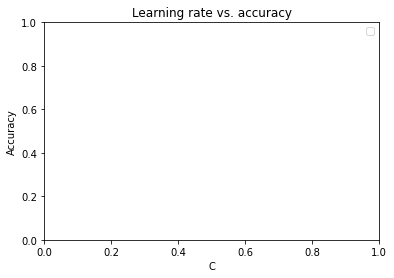

In [9]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


sgd = LogisticRegression()

# param_grid = {
#   'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#   'learning_rate': ['constant'],
#   'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
# }

param_grid = {'solver': ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga'],
          'penalty': ['l1', 'l2'],
          'C': [1000, 10, 1, 0.1, 0.001, 0.001],
          'max_iter': [4000]
         }

grid_search = GridSearchCV(sgd, param_grid=param_grid)

grid_search.fit(X_train, y_train.ravel())

result = grid_search.cv_results_
estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

mean_scores = result['mean_test_score']

scores_combo = {} # {[alpha_value]: { x: [eta0 values], y: [scores]}}

for idx, param in enumerate(result['params']):
    alpha = param['penalty']
    eta0 = param['C']
    score = mean_scores[idx]
    if scores_combo.get(alpha):
        scores_combo[alpha]['x'].append(eta0)
        scores_combo[alpha]['y'].append(score)
    else:
        scores_combo[alpha] = {'x': [eta0], 'y': [score]}
    

print(mean_scores)
print(scores_combo)
print('best score', best_score)
print('best params', best_params)

for key in scores_combo:
    if key == 0.1 or key == 0.01:
        values = scores_combo[key]
        label = f'penalty={key}'
        plt.scatter(values['x'], values['y'], label=label)
        
plt.title('Learning rate vs. accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')

plt.legend()
plt.show()